In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES']='2'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime
import pandas as pd
from tqdm import tqdm
from readTFR import *

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

2022-11-27 13:37:36.032974: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# for visual studio code
os.chdir('/home/r10222035/Boosted_V/CNN/')

# Training data 

In [2]:
kappa = 0.15
nevent = '10k'
model_name = 'CNN'

In [45]:
batch_size = 256
shuffle_size_tr = 0
dim_image = [[75, 75], [[-0.8, 0.8], [-0.8, 0.8]]]

In [46]:
sample_dir = f'/home/r10222035/Boosted_V/sample/event_samples_kappa{kappa}-{nevent}/'
print(f'Read data from {sample_dir}')
data_tr = os.path.join(sample_dir, 'train.tfrecord')
data_vl = os.path.join(sample_dir, 'valid.tfrecord')
data_te = os.path.join(sample_dir, 'test.tfrecord')

dataset_tr, tr_total = get_dataset(data_tr, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=shuffle_size_tr,
                                   N_labels=6
                                  )
dataset_vl, vl_total = get_dataset(data_vl, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=0,
                                   N_labels=6
                                  )
dataset_te, te_total = get_dataset(data_te, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=0,
                                   N_labels=6,
                                  )

labels_tr = np.vstack([x[1] for x in dataset_tr])
labels_vl = np.vstack([x[1] for x in dataset_vl])
labels_te = np.vstack([x[1] for x in dataset_te])

y_tr = np.argmax(labels_tr, axis=1)
y_vl = np.argmax(labels_vl, axis=1)
y_te = np.argmax(labels_te, axis=1)

Read data from /home/r10222035/Boosted_V/sample/event_samples_kappa0.15-10k/
The data set contains images
The data set contains images
The data set contains images


In [5]:
def count_sample_size(y, n_type=6):
    # count sample size 
    size = [(y == i).sum() for i in range(n_type)]
    return size

In [6]:
train_size = count_sample_size(y_tr)
print('Training size:', train_size)

validation_size = count_sample_size(y_vl)
print('Validation size:', validation_size)

test_size = count_sample_size(y_te)
print('Testing size:', test_size)

Training size: [277, 291, 222, 231, 252, 263]
Validation size: [34, 57, 40, 43, 34, 48]
Testing size: [94, 91, 74, 72, 90, 91]


In [7]:
for x in dataset_te.take(1):
    print(x[0][0].shape)
    print(x[0][0][:,:,0])
    a = x[0][0][:,:,0]
    b = x[0][0][:,:,1]
print(a)
c = tf.expand_dims(a, -1)
d = tf.expand_dims(b, -1)

(75, 75, 2)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(75, 75), dtype=float32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(75, 75), dtype=float32)


# Training 

## CNN

In [8]:
class CNN(tf.keras.Model):
    def __init__(self, name='CNN', dim_image=(75, 75, 2), n_class=3):
        super(CNN, self).__init__(name=name)
        
        self.ptqk = tf.keras.Sequential([
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, (6,6), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(128, (4,4), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(256, (6,6), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Dropout(0.5),
        ])
        
        """Output Layer"""
        self._output = tf.keras.layers.Dense(n_class, activation='softmax')
        
    @tf.function
    def call(self, inputs, training=False):
        latent_ptqk = self.ptqk(inputs)
        
        return self._output(latent_ptqk)

In [ ]:
model_name = 'CNN'

In [11]:
# Training parameters
train_epochs = 500
patience = 10
min_delta = 0.
learning_rate = 1e-4                                    
save_model_name = f'best_model/best_model_event_CNN_kappa{kappa}-{nevent}/'

In [12]:
# Create the model  
history=0
model = CNN(dim_image=[75,75,2], n_class=6)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point    = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', 
                                                    verbose=1, save_best_only=True)

history = model.fit(dataset_tr, validation_data=dataset_vl , epochs=train_epochs, batch_size=batch_size, callbacks=[early_stopping, check_point])

Epoch 1/500
      5/Unknown - 1s 32ms/step - loss: 16.8025 - accuracy: 0.1719
Epoch 1: val_loss improved from inf to 16.30244, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 3s 471ms/step - loss: 16.7382 - accuracy: 0.1810 - val_loss: 16.3024 - val_accuracy: 0.1797
Epoch 2/500
5/6 [========================>.....] - ETA: 0s - loss: 16.0760 - accuracy: 0.2031
Epoch 2: val_loss improved from 16.30244 to 15.62307, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 402ms/step - loss: 16.0192 - accuracy: 0.1979 - val_loss: 15.6231 - val_accuracy: 0.2070
Epoch 3/500
5/6 [========================>.....] - ETA: 0s - loss: 15.3681 - accuracy: 0.1844
Epoch 3: val_loss improved from 15.62307 to 14.92409, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 369ms/step - loss: 15.3129 - accuracy: 0.1810 - val_loss: 14.9241 - val_accuracy: 0.2109
Epoch 4/500
5/6 [========================>.....] - ETA: 0s - loss: 14.6647 - accuracy: 0.2203
Epoch 4: val_loss improved from 14.92409 to 14.25485, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 383ms/step - loss: 14.6126 - accuracy: 0.2188 - val_loss: 14.2549 - val_accuracy: 0.2031
Epoch 5/500
5/6 [========================>.....] - ETA: 0s - loss: 14.0075 - accuracy: 0.2219
Epoch 5: val_loss improved from 14.25485 to 13.60787, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 391ms/step - loss: 13.9540 - accuracy: 0.2194 - val_loss: 13.6079 - val_accuracy: 0.1914
Epoch 6/500
5/6 [========================>.....] - ETA: 0s - loss: 13.3680 - accuracy: 0.2180
Epoch 6: val_loss improved from 13.60787 to 12.98694, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 485ms/step - loss: 13.3201 - accuracy: 0.2168 - val_loss: 12.9869 - val_accuracy: 0.2031
Epoch 7/500
5/6 [========================>.....] - ETA: 0s - loss: 12.7592 - accuracy: 0.2156
Epoch 7: val_loss improved from 12.98694 to 12.40536, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 395ms/step - loss: 12.7112 - accuracy: 0.2103 - val_loss: 12.4054 - val_accuracy: 0.1836
Epoch 8/500
5/6 [========================>.....] - ETA: 0s - loss: 12.1747 - accuracy: 0.2414
Epoch 8: val_loss improved from 12.40536 to 11.85819, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 372ms/step - loss: 12.1312 - accuracy: 0.2370 - val_loss: 11.8582 - val_accuracy: 0.1797
Epoch 9/500
5/6 [========================>.....] - ETA: 0s - loss: 11.6321 - accuracy: 0.2414
Epoch 9: val_loss improved from 11.85819 to 11.34442, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 382ms/step - loss: 11.5910 - accuracy: 0.2415 - val_loss: 11.3444 - val_accuracy: 0.1836
Epoch 10/500
5/6 [========================>.....] - ETA: 0s - loss: 11.1222 - accuracy: 0.2586
Epoch 10: val_loss improved from 11.34442 to 10.86439, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 459ms/step - loss: 11.0848 - accuracy: 0.2520 - val_loss: 10.8644 - val_accuracy: 0.1523
Epoch 11/500
5/6 [========================>.....] - ETA: 0s - loss: 10.6445 - accuracy: 0.2492
Epoch 11: val_loss improved from 10.86439 to 10.41354, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 378ms/step - loss: 10.6117 - accuracy: 0.2422 - val_loss: 10.4135 - val_accuracy: 0.1562
Epoch 12/500
5/6 [========================>.....] - ETA: 0s - loss: 10.2033 - accuracy: 0.2578
Epoch 12: val_loss improved from 10.41354 to 10.00029, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 394ms/step - loss: 10.1712 - accuracy: 0.2539 - val_loss: 10.0003 - val_accuracy: 0.1719
Epoch 13/500
5/6 [========================>.....] - ETA: 0s - loss: 9.7824 - accuracy: 0.2930
Epoch 13: val_loss improved from 10.00029 to 9.60523, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 372ms/step - loss: 9.7531 - accuracy: 0.2878 - val_loss: 9.6052 - val_accuracy: 0.1836
Epoch 14/500
5/6 [========================>.....] - ETA: 0s - loss: 9.3973 - accuracy: 0.2594
Epoch 14: val_loss improved from 9.60523 to 9.24389, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 473ms/step - loss: 9.3699 - accuracy: 0.2611 - val_loss: 9.2439 - val_accuracy: 0.1758
Epoch 15/500
5/6 [========================>.....] - ETA: 0s - loss: 9.0298 - accuracy: 0.2711
Epoch 15: val_loss improved from 9.24389 to 8.91469, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 374ms/step - loss: 9.0023 - accuracy: 0.2695 - val_loss: 8.9147 - val_accuracy: 0.1836
Epoch 16/500
5/6 [========================>.....] - ETA: 0s - loss: 8.6963 - accuracy: 0.2953
Epoch 16: val_loss improved from 8.91469 to 8.60167, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 381ms/step - loss: 8.6708 - accuracy: 0.2988 - val_loss: 8.6017 - val_accuracy: 0.1758
Epoch 17/500
5/6 [========================>.....] - ETA: 0s - loss: 8.3782 - accuracy: 0.2898
Epoch 17: val_loss improved from 8.60167 to 8.31387, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 379ms/step - loss: 8.3557 - accuracy: 0.2936 - val_loss: 8.3139 - val_accuracy: 0.1641
Epoch 18/500
5/6 [========================>.....] - ETA: 0s - loss: 8.0875 - accuracy: 0.3133
Epoch 18: val_loss improved from 8.31387 to 8.03867, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 372ms/step - loss: 8.0644 - accuracy: 0.3086 - val_loss: 8.0387 - val_accuracy: 0.1797
Epoch 19/500
5/6 [========================>.....] - ETA: 0s - loss: 7.8124 - accuracy: 0.3180
Epoch 19: val_loss improved from 8.03867 to 7.80803, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 489ms/step - loss: 7.7894 - accuracy: 0.3197 - val_loss: 7.8080 - val_accuracy: 0.1641
Epoch 20/500
5/6 [========================>.....] - ETA: 0s - loss: 7.5502 - accuracy: 0.3219
Epoch 20: val_loss improved from 7.80803 to 7.56445, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 384ms/step - loss: 7.5352 - accuracy: 0.3132 - val_loss: 7.5644 - val_accuracy: 0.1875
Epoch 21/500
5/6 [========================>.....] - ETA: 0s - loss: 7.3305 - accuracy: 0.3109
Epoch 21: val_loss improved from 7.56445 to 7.34328, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 384ms/step - loss: 7.3065 - accuracy: 0.3145 - val_loss: 7.3433 - val_accuracy: 0.1797
Epoch 22/500
5/6 [========================>.....] - ETA: 0s - loss: 7.0782 - accuracy: 0.3430
Epoch 22: val_loss improved from 7.34328 to 7.15332, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 394ms/step - loss: 7.0602 - accuracy: 0.3516 - val_loss: 7.1533 - val_accuracy: 0.1523
Epoch 23/500
5/6 [========================>.....] - ETA: 0s - loss: 6.8617 - accuracy: 0.3445
Epoch 23: val_loss improved from 7.15332 to 6.96680, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 456ms/step - loss: 6.8432 - accuracy: 0.3470 - val_loss: 6.9668 - val_accuracy: 0.1602
Epoch 24/500
5/6 [========================>.....] - ETA: 0s - loss: 6.6429 - accuracy: 0.4109
Epoch 24: val_loss improved from 6.96680 to 6.79745, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 377ms/step - loss: 6.6323 - accuracy: 0.4069 - val_loss: 6.7975 - val_accuracy: 0.1836
Epoch 25/500
5/6 [========================>.....] - ETA: 0s - loss: 6.4298 - accuracy: 0.4102
Epoch 25: val_loss improved from 6.79745 to 6.63875, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 399ms/step - loss: 6.4159 - accuracy: 0.4173 - val_loss: 6.6387 - val_accuracy: 0.1680
Epoch 26/500
5/6 [========================>.....] - ETA: 0s - loss: 6.2407 - accuracy: 0.4422
Epoch 26: val_loss improved from 6.63875 to 6.47880, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 389ms/step - loss: 6.2257 - accuracy: 0.4368 - val_loss: 6.4788 - val_accuracy: 0.2031
Epoch 27/500
5/6 [========================>.....] - ETA: 0s - loss: 6.0492 - accuracy: 0.4492
Epoch 27: val_loss improved from 6.47880 to 6.35126, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 411ms/step - loss: 6.0330 - accuracy: 0.4473 - val_loss: 6.3513 - val_accuracy: 0.1797
Epoch 28/500
5/6 [========================>.....] - ETA: 0s - loss: 5.8661 - accuracy: 0.4578
Epoch 28: val_loss improved from 6.35126 to 6.21270, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 3s 498ms/step - loss: 5.8564 - accuracy: 0.4583 - val_loss: 6.2127 - val_accuracy: 0.1797
Epoch 29/500
5/6 [========================>.....] - ETA: 0s - loss: 5.6952 - accuracy: 0.4727
Epoch 29: val_loss improved from 6.21270 to 6.12204, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 389ms/step - loss: 5.6843 - accuracy: 0.4766 - val_loss: 6.1220 - val_accuracy: 0.1406
Epoch 30/500
5/6 [========================>.....] - ETA: 0s - loss: 5.5442 - accuracy: 0.4922
Epoch 30: val_loss improved from 6.12204 to 5.97028, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 386ms/step - loss: 5.5393 - accuracy: 0.4844 - val_loss: 5.9703 - val_accuracy: 0.1875
Epoch 31/500
5/6 [========================>.....] - ETA: 0s - loss: 5.3792 - accuracy: 0.5312
Epoch 31: val_loss improved from 5.97028 to 5.89573, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 382ms/step - loss: 5.3777 - accuracy: 0.5215 - val_loss: 5.8957 - val_accuracy: 0.1406
Epoch 32/500
5/6 [========================>.....] - ETA: 0s - loss: 5.2316 - accuracy: 0.5484
Epoch 32: val_loss improved from 5.89573 to 5.79173, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 459ms/step - loss: 5.2241 - accuracy: 0.5456 - val_loss: 5.7917 - val_accuracy: 0.1680
Epoch 33/500
5/6 [========================>.....] - ETA: 0s - loss: 5.0961 - accuracy: 0.5453
Epoch 33: val_loss improved from 5.79173 to 5.71275, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 378ms/step - loss: 5.0793 - accuracy: 0.5586 - val_loss: 5.7127 - val_accuracy: 0.1484
Epoch 34/500
5/6 [========================>.....] - ETA: 0s - loss: 4.9452 - accuracy: 0.6000
Epoch 34: val_loss improved from 5.71275 to 5.63724, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 388ms/step - loss: 4.9462 - accuracy: 0.5924 - val_loss: 5.6372 - val_accuracy: 0.1875
Epoch 35/500
5/6 [========================>.....] - ETA: 0s - loss: 4.8238 - accuracy: 0.5992
Epoch 35: val_loss improved from 5.63724 to 5.55843, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 380ms/step - loss: 4.8145 - accuracy: 0.6035 - val_loss: 5.5584 - val_accuracy: 0.1641
Epoch 36/500
5/6 [========================>.....] - ETA: 0s - loss: 4.6784 - accuracy: 0.6328
Epoch 36: val_loss improved from 5.55843 to 5.50128, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 460ms/step - loss: 4.6644 - accuracy: 0.6348 - val_loss: 5.5013 - val_accuracy: 0.1562
Epoch 37/500
5/6 [========================>.....] - ETA: 0s - loss: 4.5534 - accuracy: 0.6352
Epoch 37: val_loss improved from 5.50128 to 5.45187, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 369ms/step - loss: 4.5421 - accuracy: 0.6380 - val_loss: 5.4519 - val_accuracy: 0.1797
Epoch 38/500
5/6 [========================>.....] - ETA: 0s - loss: 4.4444 - accuracy: 0.6578
Epoch 38: val_loss improved from 5.45187 to 5.40115, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 374ms/step - loss: 4.4274 - accuracy: 0.6686 - val_loss: 5.4012 - val_accuracy: 0.2031
Epoch 39/500
5/6 [========================>.....] - ETA: 0s - loss: 4.3022 - accuracy: 0.7125
Epoch 39: val_loss improved from 5.40115 to 5.39506, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 374ms/step - loss: 4.2933 - accuracy: 0.7168 - val_loss: 5.3951 - val_accuracy: 0.1836
Epoch 40/500
5/6 [========================>.....] - ETA: 0s - loss: 4.1702 - accuracy: 0.7383
Epoch 40: val_loss improved from 5.39506 to 5.34957, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 389ms/step - loss: 4.1675 - accuracy: 0.7331 - val_loss: 5.3496 - val_accuracy: 0.1641
Epoch 41/500
5/6 [========================>.....] - ETA: 0s - loss: 4.0982 - accuracy: 0.7188
Epoch 41: val_loss improved from 5.34957 to 5.29296, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 454ms/step - loss: 4.0950 - accuracy: 0.7227 - val_loss: 5.2930 - val_accuracy: 0.1562
Epoch 42/500
5/6 [========================>.....] - ETA: 0s - loss: 3.9336 - accuracy: 0.7961
Epoch 42: val_loss improved from 5.29296 to 5.24057, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 388ms/step - loss: 3.9423 - accuracy: 0.7832 - val_loss: 5.2406 - val_accuracy: 0.1445
Epoch 43/500
5/6 [========================>.....] - ETA: 0s - loss: 3.8286 - accuracy: 0.8086
Epoch 43: val_loss did not improve from 5.24057
6/6 [==============================] - 0s 47ms/step - loss: 3.8297 - accuracy: 0.8047 - val_loss: 5.2879 - val_accuracy: 0.1836
Epoch 44/500
5/6 [========================>.....] - ETA: 0s - loss: 3.7377 - accuracy: 0.8141
Epoch 44: val_loss improved from 5.24057 to 5.21325, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 395ms/step - loss: 3.7309 - accuracy: 0.8125 - val_loss: 5.2132 - val_accuracy: 0.1758
Epoch 45/500
5/6 [========================>.....] - ETA: 0s - loss: 3.6334 - accuracy: 0.8461
Epoch 45: val_loss improved from 5.21325 to 5.10006, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 386ms/step - loss: 3.6266 - accuracy: 0.8490 - val_loss: 5.1001 - val_accuracy: 0.1836
Epoch 46/500
5/6 [========================>.....] - ETA: 0s - loss: 3.5085 - accuracy: 0.8773
Epoch 46: val_loss did not improve from 5.10006
6/6 [==============================] - 0s 47ms/step - loss: 3.5090 - accuracy: 0.8750 - val_loss: 5.1290 - val_accuracy: 0.1797
Epoch 47/500
5/6 [========================>.....] - ETA: 0s - loss: 3.4166 - accuracy: 0.8797
Epoch 47: val_loss did not improve from 5.10006
6/6 [==============================] - 0s 47ms/step - loss: 3.4118 - accuracy: 0.8809 - val_loss: 5.1055 - val_accuracy: 0.1602
Epoch 48/500
5/6 [========================>.....] - ETA: 0s - loss: 3.3223 - accuracy: 0.8891
Epoch 48: val_loss improved from 5.10006 to 5.09150, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 473ms/step - loss: 3.3292 - accuracy: 0.8841 - val_loss: 5.0915 - val_accuracy: 0.1797
Epoch 49/500
5/6 [========================>.....] - ETA: 0s - loss: 3.2207 - accuracy: 0.9266
Epoch 49: val_loss improved from 5.09150 to 5.07851, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 387ms/step - loss: 3.2177 - accuracy: 0.9251 - val_loss: 5.0785 - val_accuracy: 0.1953
Epoch 50/500
5/6 [========================>.....] - ETA: 0s - loss: 3.1792 - accuracy: 0.9133
Epoch 50: val_loss improved from 5.07851 to 4.99621, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 413ms/step - loss: 3.1728 - accuracy: 0.9154 - val_loss: 4.9962 - val_accuracy: 0.2188
Epoch 51/500
5/6 [========================>.....] - ETA: 0s - loss: 3.1035 - accuracy: 0.9187
Epoch 51: val_loss did not improve from 4.99621
6/6 [==============================] - 0s 48ms/step - loss: 3.0964 - accuracy: 0.9225 - val_loss: 5.0064 - val_accuracy: 0.1875
Epoch 52/500
5/6 [========================>.....] - ETA: 0s - loss: 3.0611 - accuracy: 0.9187
Epoch 52: val_loss did not improve from 4.99621
6/6 [==============================] - 0s 47ms/step - loss: 3.0600 - accuracy: 0.9141 - val_loss: 5.0933 - val_accuracy: 0.1680
Epoch 53/500
5/6 [========================>.....] - ETA: 0s - loss: 2.9668 - accuracy: 0.9383
Epoch 53: val_loss did not improve from 4.99621
6/6 [==============================] - 0s 47ms/step - loss: 2.9639 - accuracy: 0.9342 - val_loss: 5.2205 - val_accuracy: 0.1523
Epoch 54/500
5/6 [========================>.....] - ETA: 0s -

INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 393ms/step - loss: 2.7946 - accuracy: 0.9505 - val_loss: 4.9809 - val_accuracy: 0.2266
Epoch 57/500
5/6 [========================>.....] - ETA: 0s - loss: 2.7740 - accuracy: 0.9391
Epoch 57: val_loss did not improve from 4.98088
6/6 [==============================] - 0s 48ms/step - loss: 2.7583 - accuracy: 0.9453 - val_loss: 5.3051 - val_accuracy: 0.1953
Epoch 58/500
5/6 [========================>.....] - ETA: 0s - loss: 2.7380 - accuracy: 0.9328
Epoch 58: val_loss did not improve from 4.98088
6/6 [==============================] - 0s 47ms/step - loss: 2.7199 - accuracy: 0.9421 - val_loss: 5.1686 - val_accuracy: 0.1758
Epoch 59/500
5/6 [========================>.....] - ETA: 0s - loss: 2.7203 - accuracy: 0.9289
Epoch 59: val_loss improved from 4.98088 to 4.91114, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 392ms/step - loss: 2.7108 - accuracy: 0.9342 - val_loss: 4.9111 - val_accuracy: 0.1914
Epoch 60/500
5/6 [========================>.....] - ETA: 0s - loss: 2.7234 - accuracy: 0.8992
Epoch 60: val_loss improved from 4.91114 to 4.69636, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 3s 510ms/step - loss: 2.7543 - accuracy: 0.8841 - val_loss: 4.6964 - val_accuracy: 0.1680
Epoch 61/500
5/6 [========================>.....] - ETA: 0s - loss: 2.7334 - accuracy: 0.8766
Epoch 61: val_loss did not improve from 4.69636
6/6 [==============================] - 0s 47ms/step - loss: 2.7702 - accuracy: 0.8600 - val_loss: 5.2526 - val_accuracy: 0.1445
Epoch 62/500
5/6 [========================>.....] - ETA: 0s - loss: 2.7890 - accuracy: 0.8539
Epoch 62: val_loss improved from 4.69636 to 4.59159, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 393ms/step - loss: 2.7758 - accuracy: 0.8574 - val_loss: 4.5916 - val_accuracy: 0.1914
Epoch 63/500
5/6 [========================>.....] - ETA: 0s - loss: 2.5635 - accuracy: 0.9656
Epoch 63: val_loss did not improve from 4.59159
6/6 [==============================] - 0s 51ms/step - loss: 2.5623 - accuracy: 0.9648 - val_loss: 4.9127 - val_accuracy: 0.1797
Epoch 64/500
5/6 [========================>.....] - ETA: 0s - loss: 2.5091 - accuracy: 0.9375
Epoch 64: val_loss did not improve from 4.59159
6/6 [==============================] - 0s 47ms/step - loss: 2.4924 - accuracy: 0.9447 - val_loss: 5.2369 - val_accuracy: 0.1680
Epoch 65/500
5/6 [========================>.....] - ETA: 0s - loss: 2.4405 - accuracy: 0.9516
Epoch 65: val_loss did not improve from 4.59159
6/6 [==============================] - 0s 48ms/step - loss: 2.4294 - accuracy: 0.9557 - val_loss: 4.9633 - val_accuracy: 0.2227
Epoch 66/500
5/6 [========================>.....] - ETA: 0s -

INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 417ms/step - loss: 2.2814 - accuracy: 0.9870 - val_loss: 4.5835 - val_accuracy: 0.2148
Epoch 68/500
5/6 [========================>.....] - ETA: 0s - loss: 2.2232 - accuracy: 0.9937
Epoch 68: val_loss did not improve from 4.58355
6/6 [==============================] - 0s 47ms/step - loss: 2.2208 - accuracy: 0.9928 - val_loss: 4.7611 - val_accuracy: 0.2031
Epoch 69/500
5/6 [========================>.....] - ETA: 0s - loss: 2.1896 - accuracy: 0.9937
Epoch 69: val_loss did not improve from 4.58355
6/6 [==============================] - 0s 48ms/step - loss: 2.1849 - accuracy: 0.9935 - val_loss: 4.7034 - val_accuracy: 0.1875
Epoch 70/500
5/6 [========================>.....] - ETA: 0s - loss: 2.1414 - accuracy: 0.9969
Epoch 70: val_loss improved from 4.58355 to 4.57773, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 385ms/step - loss: 2.1394 - accuracy: 0.9954 - val_loss: 4.5777 - val_accuracy: 0.1875
Epoch 71/500
5/6 [========================>.....] - ETA: 0s - loss: 2.1036 - accuracy: 0.9953
Epoch 71: val_loss did not improve from 4.57773
6/6 [==============================] - 0s 47ms/step - loss: 2.1026 - accuracy: 0.9954 - val_loss: 4.6513 - val_accuracy: 0.2070
Epoch 72/500
5/6 [========================>.....] - ETA: 0s - loss: 2.0640 - accuracy: 0.9969
Epoch 72: val_loss did not improve from 4.57773
6/6 [==============================] - 0s 46ms/step - loss: 2.0607 - accuracy: 0.9967 - val_loss: 4.5978 - val_accuracy: 0.2188
Epoch 73/500
5/6 [========================>.....] - ETA: 0s - loss: 2.0282 - accuracy: 0.9969
Epoch 73: val_loss improved from 4.57773 to 4.49655, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 457ms/step - loss: 2.0288 - accuracy: 0.9948 - val_loss: 4.4966 - val_accuracy: 0.2070
Epoch 74/500
5/6 [========================>.....] - ETA: 0s - loss: 1.9985 - accuracy: 0.9953
Epoch 74: val_loss improved from 4.49655 to 4.49290, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 393ms/step - loss: 1.9943 - accuracy: 0.9961 - val_loss: 4.4929 - val_accuracy: 0.1914
Epoch 75/500
5/6 [========================>.....] - ETA: 0s - loss: 1.9589 - accuracy: 0.9984
Epoch 75: val_loss improved from 4.49290 to 4.47266, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 381ms/step - loss: 1.9570 - accuracy: 0.9974 - val_loss: 4.4727 - val_accuracy: 0.1836
Epoch 76/500
5/6 [========================>.....] - ETA: 0s - loss: 1.9342 - accuracy: 0.9930
Epoch 76: val_loss improved from 4.47266 to 4.37358, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 385ms/step - loss: 1.9297 - accuracy: 0.9941 - val_loss: 4.3736 - val_accuracy: 0.2070
Epoch 77/500
5/6 [========================>.....] - ETA: 0s - loss: 1.8987 - accuracy: 0.9984
Epoch 77: val_loss improved from 4.37358 to 4.35251, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 400ms/step - loss: 1.8949 - accuracy: 0.9987 - val_loss: 4.3525 - val_accuracy: 0.2266
Epoch 78/500
5/6 [========================>.....] - ETA: 0s - loss: 1.8693 - accuracy: 0.9969
Epoch 78: val_loss did not improve from 4.35251
6/6 [==============================] - 0s 47ms/step - loss: 1.8674 - accuracy: 0.9974 - val_loss: 4.4392 - val_accuracy: 0.2031
Epoch 79/500
5/6 [========================>.....] - ETA: 0s - loss: 1.8437 - accuracy: 0.9961
Epoch 79: val_loss did not improve from 4.35251
6/6 [==============================] - 0s 46ms/step - loss: 1.8394 - accuracy: 0.9967 - val_loss: 4.3747 - val_accuracy: 0.2031
Epoch 80/500
5/6 [========================>.....] - ETA: 0s - loss: 1.8123 - accuracy: 0.9969
Epoch 80: val_loss improved from 4.35251 to 4.25950, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 471ms/step - loss: 1.8082 - accuracy: 0.9974 - val_loss: 4.2595 - val_accuracy: 0.2109
Epoch 81/500
5/6 [========================>.....] - ETA: 0s - loss: 1.7787 - accuracy: 0.9992
Epoch 81: val_loss did not improve from 4.25950
6/6 [==============================] - 0s 48ms/step - loss: 1.7765 - accuracy: 0.9987 - val_loss: 4.2860 - val_accuracy: 0.2305
Epoch 82/500
5/6 [========================>.....] - ETA: 0s - loss: 1.7474 - accuracy: 0.9984
Epoch 82: val_loss did not improve from 4.25950
6/6 [==============================] - 0s 47ms/step - loss: 1.7495 - accuracy: 0.9974 - val_loss: 4.2827 - val_accuracy: 0.2148
Epoch 83/500
5/6 [========================>.....] - ETA: 0s - loss: 1.7277 - accuracy: 0.9984
Epoch 83: val_loss improved from 4.25950 to 4.20680, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 397ms/step - loss: 1.7270 - accuracy: 0.9967 - val_loss: 4.2068 - val_accuracy: 0.2227
Epoch 84/500
5/6 [========================>.....] - ETA: 0s - loss: 1.6972 - accuracy: 0.9977
Epoch 84: val_loss improved from 4.20680 to 4.14636, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 395ms/step - loss: 1.6949 - accuracy: 0.9967 - val_loss: 4.1464 - val_accuracy: 0.2227
Epoch 85/500
5/6 [========================>.....] - ETA: 0s - loss: 1.6714 - accuracy: 0.9969
Epoch 85: val_loss did not improve from 4.14636
6/6 [==============================] - 0s 48ms/step - loss: 1.6682 - accuracy: 0.9974 - val_loss: 4.1496 - val_accuracy: 0.2227
Epoch 86/500
5/6 [========================>.....] - ETA: 0s - loss: 1.6389 - accuracy: 0.9977
Epoch 86: val_loss did not improve from 4.14636
6/6 [==============================] - 0s 48ms/step - loss: 1.6376 - accuracy: 0.9980 - val_loss: 4.1694 - val_accuracy: 0.2227
Epoch 87/500
5/6 [========================>.....] - ETA: 0s - loss: 1.6202 - accuracy: 0.9969
Epoch 87: val_loss improved from 4.14636 to 4.12421, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 398ms/step - loss: 1.6170 - accuracy: 0.9967 - val_loss: 4.1242 - val_accuracy: 0.2344
Epoch 88/500
5/6 [========================>.....] - ETA: 0s - loss: 1.5933 - accuracy: 0.9984
Epoch 88: val_loss improved from 4.12421 to 4.09975, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 3s 494ms/step - loss: 1.5925 - accuracy: 0.9987 - val_loss: 4.0998 - val_accuracy: 0.2148
Epoch 89/500
5/6 [========================>.....] - ETA: 0s - loss: 1.5577 - accuracy: 1.0000
Epoch 89: val_loss improved from 4.09975 to 4.09678, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 403ms/step - loss: 1.5571 - accuracy: 0.9993 - val_loss: 4.0968 - val_accuracy: 0.2148
Epoch 90/500
5/6 [========================>.....] - ETA: 0s - loss: 1.5424 - accuracy: 0.9977
Epoch 90: val_loss improved from 4.09678 to 4.00073, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 393ms/step - loss: 1.5400 - accuracy: 0.9974 - val_loss: 4.0007 - val_accuracy: 0.2266
Epoch 91/500
5/6 [========================>.....] - ETA: 0s - loss: 1.5199 - accuracy: 0.9977
Epoch 91: val_loss improved from 4.00073 to 3.98701, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 404ms/step - loss: 1.5179 - accuracy: 0.9967 - val_loss: 3.9870 - val_accuracy: 0.2305
Epoch 92/500
5/6 [========================>.....] - ETA: 0s - loss: 1.4912 - accuracy: 1.0000
Epoch 92: val_loss did not improve from 3.98701
6/6 [==============================] - 0s 48ms/step - loss: 1.4889 - accuracy: 1.0000 - val_loss: 4.0027 - val_accuracy: 0.2148
Epoch 93/500
5/6 [========================>.....] - ETA: 0s - loss: 1.4688 - accuracy: 0.9984
Epoch 93: val_loss improved from 3.98701 to 3.96788, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 476ms/step - loss: 1.4655 - accuracy: 0.9987 - val_loss: 3.9679 - val_accuracy: 0.2227
Epoch 94/500
5/6 [========================>.....] - ETA: 0s - loss: 1.4401 - accuracy: 1.0000
Epoch 94: val_loss improved from 3.96788 to 3.93269, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 403ms/step - loss: 1.4390 - accuracy: 0.9993 - val_loss: 3.9327 - val_accuracy: 0.2344
Epoch 95/500
5/6 [========================>.....] - ETA: 0s - loss: 1.4237 - accuracy: 0.9984
Epoch 95: val_loss improved from 3.93269 to 3.91077, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 400ms/step - loss: 1.4219 - accuracy: 0.9974 - val_loss: 3.9108 - val_accuracy: 0.2227
Epoch 96/500
5/6 [========================>.....] - ETA: 0s - loss: 1.3979 - accuracy: 0.9984
Epoch 96: val_loss improved from 3.91077 to 3.90067, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 398ms/step - loss: 1.3955 - accuracy: 0.9987 - val_loss: 3.9007 - val_accuracy: 0.2148
Epoch 97/500
5/6 [========================>.....] - ETA: 0s - loss: 1.3734 - accuracy: 1.0000
Epoch 97: val_loss did not improve from 3.90067
6/6 [==============================] - 0s 48ms/step - loss: 1.3739 - accuracy: 0.9993 - val_loss: 3.9111 - val_accuracy: 0.2344
Epoch 98/500
5/6 [========================>.....] - ETA: 0s - loss: 1.3573 - accuracy: 0.9984
Epoch 98: val_loss improved from 3.90067 to 3.87641, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 390ms/step - loss: 1.3549 - accuracy: 0.9987 - val_loss: 3.8764 - val_accuracy: 0.2422
Epoch 99/500
5/6 [========================>.....] - ETA: 0s - loss: 1.3380 - accuracy: 0.9992
Epoch 99: val_loss improved from 3.87641 to 3.85276, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 3s 496ms/step - loss: 1.3365 - accuracy: 0.9993 - val_loss: 3.8528 - val_accuracy: 0.2070
Epoch 100/500
5/6 [========================>.....] - ETA: 0s - loss: 1.3162 - accuracy: 0.9977
Epoch 100: val_loss improved from 3.85276 to 3.79179, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 393ms/step - loss: 1.3161 - accuracy: 0.9980 - val_loss: 3.7918 - val_accuracy: 0.2148
Epoch 101/500
5/6 [========================>.....] - ETA: 0s - loss: 1.2978 - accuracy: 0.9969
Epoch 101: val_loss did not improve from 3.79179
6/6 [==============================] - 0s 47ms/step - loss: 1.2950 - accuracy: 0.9974 - val_loss: 3.7968 - val_accuracy: 0.2266
Epoch 102/500
5/6 [========================>.....] - ETA: 0s - loss: 1.2823 - accuracy: 0.9992
Epoch 102: val_loss improved from 3.79179 to 3.73274, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 379ms/step - loss: 1.2797 - accuracy: 0.9993 - val_loss: 3.7327 - val_accuracy: 0.2383
Epoch 103/500
5/6 [========================>.....] - ETA: 0s - loss: 1.2554 - accuracy: 1.0000
Epoch 103: val_loss improved from 3.73274 to 3.71767, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 406ms/step - loss: 1.2541 - accuracy: 1.0000 - val_loss: 3.7177 - val_accuracy: 0.2305
Epoch 104/500
5/6 [========================>.....] - ETA: 0s - loss: 1.2331 - accuracy: 0.9984
Epoch 104: val_loss did not improve from 3.71767
6/6 [==============================] - 0s 48ms/step - loss: 1.2329 - accuracy: 0.9980 - val_loss: 3.7219 - val_accuracy: 0.2148
Epoch 105/500
5/6 [========================>.....] - ETA: 0s - loss: 1.2205 - accuracy: 0.9984
Epoch 105: val_loss improved from 3.71767 to 3.70748, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 484ms/step - loss: 1.2177 - accuracy: 0.9987 - val_loss: 3.7075 - val_accuracy: 0.2266
Epoch 106/500
5/6 [========================>.....] - ETA: 0s - loss: 1.1982 - accuracy: 0.9992
Epoch 106: val_loss improved from 3.70748 to 3.67138, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 399ms/step - loss: 1.1984 - accuracy: 0.9993 - val_loss: 3.6714 - val_accuracy: 0.2344
Epoch 107/500
5/6 [========================>.....] - ETA: 0s - loss: 1.1835 - accuracy: 0.9984
Epoch 107: val_loss improved from 3.67138 to 3.63031, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 406ms/step - loss: 1.1819 - accuracy: 0.9987 - val_loss: 3.6303 - val_accuracy: 0.2500
Epoch 108/500
5/6 [========================>.....] - ETA: 0s - loss: 1.1606 - accuracy: 0.9992
Epoch 108: val_loss did not improve from 3.63031
6/6 [==============================] - 0s 48ms/step - loss: 1.1602 - accuracy: 0.9993 - val_loss: 3.6408 - val_accuracy: 0.2500
Epoch 109/500
5/6 [========================>.....] - ETA: 0s - loss: 1.1404 - accuracy: 0.9992
Epoch 109: val_loss did not improve from 3.63031
6/6 [==============================] - 0s 47ms/step - loss: 1.1395 - accuracy: 0.9993 - val_loss: 3.6626 - val_accuracy: 0.2266
Epoch 110/500
5/6 [========================>.....] - ETA: 0s - loss: 1.1270 - accuracy: 1.0000
Epoch 110: val_loss did not improve from 3.63031
6/6 [==============================] - 0s 47ms/step - loss: 1.1255 - accuracy: 1.0000 - val_loss: 3.6584 - val_accuracy: 0.2422
Epoch 111/500
5/6 [========================>.....] - ET

INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 418ms/step - loss: 1.0778 - accuracy: 1.0000 - val_loss: 3.5774 - val_accuracy: 0.2500
Epoch 114/500
5/6 [========================>.....] - ETA: 0s - loss: 1.0626 - accuracy: 0.9984
Epoch 114: val_loss improved from 3.57737 to 3.55081, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 482ms/step - loss: 1.0625 - accuracy: 0.9987 - val_loss: 3.5508 - val_accuracy: 0.2461
Epoch 115/500
5/6 [========================>.....] - ETA: 0s - loss: 1.0486 - accuracy: 0.9992
Epoch 115: val_loss did not improve from 3.55081
6/6 [==============================] - 0s 48ms/step - loss: 1.0461 - accuracy: 0.9993 - val_loss: 3.5697 - val_accuracy: 0.2383
Epoch 116/500
5/6 [========================>.....] - ETA: 0s - loss: 1.0350 - accuracy: 0.9984
Epoch 116: val_loss improved from 3.55081 to 3.50726, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 388ms/step - loss: 1.0353 - accuracy: 0.9980 - val_loss: 3.5073 - val_accuracy: 0.2617
Epoch 117/500
5/6 [========================>.....] - ETA: 0s - loss: 1.0170 - accuracy: 1.0000
Epoch 117: val_loss did not improve from 3.50726
6/6 [==============================] - 0s 48ms/step - loss: 1.0163 - accuracy: 1.0000 - val_loss: 3.5315 - val_accuracy: 0.2461
Epoch 118/500
5/6 [========================>.....] - ETA: 0s - loss: 0.9991 - accuracy: 0.9992
Epoch 118: val_loss did not improve from 3.50726
6/6 [==============================] - 0s 48ms/step - loss: 0.9981 - accuracy: 0.9993 - val_loss: 3.5370 - val_accuracy: 0.2539
Epoch 119/500
5/6 [========================>.....] - ETA: 0s - loss: 0.9853 - accuracy: 1.0000
Epoch 119: val_loss did not improve from 3.50726
6/6 [==============================] - 0s 47ms/step - loss: 0.9861 - accuracy: 0.9987 - val_loss: 3.5156 - val_accuracy: 0.2422
Epoch 120/500
5/6 [========================>.....] - ET

INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 383ms/step - loss: 0.9456 - accuracy: 0.9980 - val_loss: 3.4418 - val_accuracy: 0.2617
Epoch 123/500
5/6 [========================>.....] - ETA: 0s - loss: 0.9315 - accuracy: 0.9992
Epoch 123: val_loss improved from 3.44176 to 3.43926, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 403ms/step - loss: 0.9311 - accuracy: 0.9993 - val_loss: 3.4393 - val_accuracy: 0.2773
Epoch 124/500
5/6 [========================>.....] - ETA: 0s - loss: 0.9192 - accuracy: 0.9992
Epoch 124: val_loss did not improve from 3.43926
6/6 [==============================] - 0s 48ms/step - loss: 0.9184 - accuracy: 0.9993 - val_loss: 3.5379 - val_accuracy: 0.2227
Epoch 125/500
5/6 [========================>.....] - ETA: 0s - loss: 0.9051 - accuracy: 1.0000
Epoch 125: val_loss did not improve from 3.43926
6/6 [==============================] - 0s 48ms/step - loss: 0.9047 - accuracy: 0.9993 - val_loss: 3.4708 - val_accuracy: 0.2344
Epoch 126/500
5/6 [========================>.....] - ETA: 0s - loss: 0.8900 - accuracy: 0.9992
Epoch 126: val_loss did not improve from 3.43926
6/6 [==============================] - 0s 49ms/step - loss: 0.8894 - accuracy: 0.9987 - val_loss: 3.4628 - val_accuracy: 0.2188
Epoch 127/500
5/6 [========================>.....] - ET

INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 394ms/step - loss: 0.8752 - accuracy: 1.0000 - val_loss: 3.3991 - val_accuracy: 0.2305
Epoch 128/500
5/6 [========================>.....] - ETA: 0s - loss: 0.8643 - accuracy: 0.9992
Epoch 128: val_loss did not improve from 3.39915
6/6 [==============================] - 0s 48ms/step - loss: 0.8643 - accuracy: 0.9987 - val_loss: 3.4360 - val_accuracy: 0.2578
Epoch 129/500
5/6 [========================>.....] - ETA: 0s - loss: 0.8549 - accuracy: 0.9977
Epoch 129: val_loss improved from 3.39915 to 3.39759, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 3s 561ms/step - loss: 0.8531 - accuracy: 0.9980 - val_loss: 3.3976 - val_accuracy: 0.2930
Epoch 130/500
5/6 [========================>.....] - ETA: 0s - loss: 0.8420 - accuracy: 0.9984
Epoch 130: val_loss did not improve from 3.39759
6/6 [==============================] - 0s 47ms/step - loss: 0.8389 - accuracy: 0.9987 - val_loss: 3.4477 - val_accuracy: 0.2578
Epoch 131/500
5/6 [========================>.....] - ETA: 0s - loss: 0.8294 - accuracy: 0.9977
Epoch 131: val_loss improved from 3.39759 to 3.37956, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 416ms/step - loss: 0.8287 - accuracy: 0.9974 - val_loss: 3.3796 - val_accuracy: 0.2188
Epoch 132/500
5/6 [========================>.....] - ETA: 0s - loss: 0.8172 - accuracy: 0.9984
Epoch 132: val_loss improved from 3.37956 to 3.34274, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 408ms/step - loss: 0.8178 - accuracy: 0.9987 - val_loss: 3.3427 - val_accuracy: 0.2344
Epoch 133/500
5/6 [========================>.....] - ETA: 0s - loss: 0.8064 - accuracy: 0.9984
Epoch 133: val_loss did not improve from 3.34274
6/6 [==============================] - 0s 53ms/step - loss: 0.8046 - accuracy: 0.9987 - val_loss: 3.3547 - val_accuracy: 0.2617
Epoch 134/500
5/6 [========================>.....] - ETA: 0s - loss: 0.7937 - accuracy: 1.0000
Epoch 134: val_loss did not improve from 3.34274
6/6 [==============================] - 0s 48ms/step - loss: 0.7910 - accuracy: 1.0000 - val_loss: 3.3518 - val_accuracy: 0.2539
Epoch 135/500
5/6 [========================>.....] - ETA: 0s - loss: 0.7804 - accuracy: 1.0000
Epoch 135: val_loss improved from 3.34274 to 3.33742, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 423ms/step - loss: 0.7785 - accuracy: 1.0000 - val_loss: 3.3374 - val_accuracy: 0.2500
Epoch 136/500
5/6 [========================>.....] - ETA: 0s - loss: 0.7686 - accuracy: 0.9984
Epoch 136: val_loss improved from 3.33742 to 3.29300, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 3s 531ms/step - loss: 0.7680 - accuracy: 0.9987 - val_loss: 3.2930 - val_accuracy: 0.2656
Epoch 137/500
5/6 [========================>.....] - ETA: 0s - loss: 0.7588 - accuracy: 0.9992
Epoch 137: val_loss improved from 3.29300 to 3.27377, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 391ms/step - loss: 0.7565 - accuracy: 0.9993 - val_loss: 3.2738 - val_accuracy: 0.2461
Epoch 138/500
5/6 [========================>.....] - ETA: 0s - loss: 0.7428 - accuracy: 0.9984
Epoch 138: val_loss did not improve from 3.27377
6/6 [==============================] - 0s 48ms/step - loss: 0.7418 - accuracy: 0.9987 - val_loss: 3.3424 - val_accuracy: 0.2422
Epoch 139/500
5/6 [========================>.....] - ETA: 0s - loss: 0.7365 - accuracy: 1.0000
Epoch 139: val_loss did not improve from 3.27377
6/6 [==============================] - 0s 47ms/step - loss: 0.7354 - accuracy: 1.0000 - val_loss: 3.2817 - val_accuracy: 0.2383
Epoch 140/500
5/6 [========================>.....] - ETA: 0s - loss: 0.7247 - accuracy: 1.0000
Epoch 140: val_loss improved from 3.27377 to 3.25664, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 410ms/step - loss: 0.7255 - accuracy: 1.0000 - val_loss: 3.2566 - val_accuracy: 0.2539
Epoch 141/500
5/6 [========================>.....] - ETA: 0s - loss: 0.7148 - accuracy: 0.9984
Epoch 141: val_loss did not improve from 3.25664
6/6 [==============================] - 0s 47ms/step - loss: 0.7143 - accuracy: 0.9987 - val_loss: 3.3272 - val_accuracy: 0.2305
Epoch 142/500
5/6 [========================>.....] - ETA: 0s - loss: 0.7062 - accuracy: 0.9992
Epoch 142: val_loss did not improve from 3.25664
6/6 [==============================] - 0s 48ms/step - loss: 0.7049 - accuracy: 0.9993 - val_loss: 3.2835 - val_accuracy: 0.2500
Epoch 143/500
5/6 [========================>.....] - ETA: 0s - loss: 0.6931 - accuracy: 0.9984
Epoch 143: val_loss did not improve from 3.25664
6/6 [==============================] - 0s 47ms/step - loss: 0.6919 - accuracy: 0.9987 - val_loss: 3.2683 - val_accuracy: 0.2617
Epoch 144/500
5/6 [========================>.....] - ET

INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 410ms/step - loss: 0.6820 - accuracy: 0.9993 - val_loss: 3.2342 - val_accuracy: 0.2617
Epoch 145/500
5/6 [========================>.....] - ETA: 0s - loss: 0.6743 - accuracy: 1.0000
Epoch 145: val_loss improved from 3.23421 to 3.20568, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 397ms/step - loss: 0.6745 - accuracy: 1.0000 - val_loss: 3.2057 - val_accuracy: 0.2422
Epoch 146/500
5/6 [========================>.....] - ETA: 0s - loss: 0.6720 - accuracy: 0.9984
Epoch 146: val_loss improved from 3.20568 to 3.17769, saving model to best_model/best_model_event_CNN_kappa0.15-10k/


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 3s 519ms/step - loss: 0.6695 - accuracy: 0.9987 - val_loss: 3.1777 - val_accuracy: 0.2305
Epoch 147/500
5/6 [========================>.....] - ETA: 0s - loss: 0.6571 - accuracy: 0.9992
Epoch 147: val_loss did not improve from 3.17769
6/6 [==============================] - 0s 47ms/step - loss: 0.6560 - accuracy: 0.9993 - val_loss: 3.2578 - val_accuracy: 0.2305
Epoch 148/500
5/6 [========================>.....] - ETA: 0s - loss: 0.6490 - accuracy: 1.0000
Epoch 148: val_loss did not improve from 3.17769
6/6 [==============================] - 0s 47ms/step - loss: 0.6466 - accuracy: 1.0000 - val_loss: 3.2913 - val_accuracy: 0.2383
Epoch 149/500
5/6 [========================>.....] - ETA: 0s - loss: 0.6422 - accuracy: 0.9992
Epoch 149: val_loss did not improve from 3.17769
6/6 [==============================] - 0s 47ms/step - loss: 0.6406 - accuracy: 0.9993 - val_loss: 3.3017 - val_accuracy: 0.2227
Epoch 150/500
5/6 [========================>.....] - ET

INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 393ms/step - loss: 0.6241 - accuracy: 0.9980 - val_loss: 3.1403 - val_accuracy: 0.2500
Epoch 152/500
5/6 [========================>.....] - ETA: 0s - loss: 0.6156 - accuracy: 0.9984
Epoch 152: val_loss did not improve from 3.14031
6/6 [==============================] - 0s 47ms/step - loss: 0.6154 - accuracy: 0.9987 - val_loss: 3.1528 - val_accuracy: 0.2812
Epoch 153/500
5/6 [========================>.....] - ETA: 0s - loss: 0.6081 - accuracy: 0.9992
Epoch 153: val_loss did not improve from 3.14031
6/6 [==============================] - 0s 47ms/step - loss: 0.6062 - accuracy: 0.9993 - val_loss: 3.2019 - val_accuracy: 0.2617
Epoch 154/500
5/6 [========================>.....] - ETA: 0s - loss: 0.5993 - accuracy: 1.0000
Epoch 154: val_loss did not improve from 3.14031
6/6 [==============================] - 0s 47ms/step - loss: 0.5983 - accuracy: 1.0000 - val_loss: 3.1719 - val_accuracy: 0.2461
Epoch 155/500
5/6 [========================>.....] - ET

INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 420ms/step - loss: 0.5604 - accuracy: 0.9993 - val_loss: 3.0902 - val_accuracy: 0.2461
Epoch 159/500
5/6 [========================>.....] - ETA: 0s - loss: 0.5578 - accuracy: 0.9992
Epoch 159: val_loss did not improve from 3.09015
6/6 [==============================] - 0s 51ms/step - loss: 0.5564 - accuracy: 0.9993 - val_loss: 3.1343 - val_accuracy: 0.2383
Epoch 160/500
5/6 [========================>.....] - ETA: 0s - loss: 0.5519 - accuracy: 1.0000
Epoch 160: val_loss did not improve from 3.09015
6/6 [==============================] - 0s 48ms/step - loss: 0.5511 - accuracy: 1.0000 - val_loss: 3.1554 - val_accuracy: 0.2500
Epoch 161/500
5/6 [========================>.....] - ETA: 0s - loss: 0.5452 - accuracy: 0.9992
Epoch 161: val_loss did not improve from 3.09015
6/6 [==============================] - 0s 47ms/step - loss: 0.5463 - accuracy: 0.9993 - val_loss: 3.2158 - val_accuracy: 0.2539
Epoch 162/500
5/6 [========================>.....] - ET

INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


INFO:tensorflow:Assets written to: best_model/best_model_event_CNN_kappa0.15-10k/assets


6/6 [==============================] - 2s 415ms/step - loss: 0.5297 - accuracy: 0.9948 - val_loss: 3.0248 - val_accuracy: 0.2383
Epoch 167/500
5/6 [========================>.....] - ETA: 0s - loss: 0.5242 - accuracy: 0.9984
Epoch 167: val_loss did not improve from 3.02477
6/6 [==============================] - 0s 47ms/step - loss: 0.5262 - accuracy: 0.9974 - val_loss: 3.0408 - val_accuracy: 0.2227
Epoch 168/500
5/6 [========================>.....] - ETA: 0s - loss: 0.5175 - accuracy: 0.9977
Epoch 168: val_loss did not improve from 3.02477
6/6 [==============================] - 0s 48ms/step - loss: 0.5178 - accuracy: 0.9980 - val_loss: 3.1846 - val_accuracy: 0.2188
Epoch 169/500
5/6 [========================>.....] - ETA: 0s - loss: 0.5165 - accuracy: 0.9961
Epoch 169: val_loss did not improve from 3.02477
6/6 [==============================] - 0s 47ms/step - loss: 0.5148 - accuracy: 0.9967 - val_loss: 3.3560 - val_accuracy: 0.2031
Epoch 170/500
5/6 [========================>.....] - ET

## CNN2 

In [16]:
class CNNsq(tf.keras.Model):
    def __init__(self, name='CNNsq', dim_image=(75, 75, 2), n_class=3):
        super(CNNsq, self).__init__(name=name)
        
        """h2ptj Channel"""
        self.h2ptj = tf.keras.Sequential([
            # input tensor dimension must be (batch_size, rows, cols, channels)
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:, :, :, 0], -1)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(128, (5,5), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(256, (5,5), padding='same', activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Dropout(0.5),
        ])

        """h2Qkj Channel"""
        self.h2Qkj = tf.keras.Sequential([
            # input tensor dimension must be (batch_size, rows, cols, channels)
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:, :, :, 1], -1)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(64, (4,4), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, (4,4), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Conv2D(256, (6,6), padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D((2,2)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
            tf.keras.layers.Dropout(0.5),
        ])
        
        """Output Layer"""
        self._output = tf.keras.layers.Dense(n_class, activation='softmax')
        
    @tf.function
    def call(self, inputs, training=False):
        """h2ptj"""
        latent_h2ptj = self.h2ptj(inputs)

        """h2Qkj"""
        latent_h2Qkj = self.h2Qkj(inputs)
        
        """Output"""
        latent_all = tf.concat([latent_h2ptj, latent_h2Qkj], axis=1)
        
        return self._output(latent_all)

In [ ]:
model_name = 'CNNsq'

In [19]:
# Training parameters
train_epochs = 500
patience = 10
min_delta = 0.
learning_rate = 1e-4                                    
save_model_name = f'best_model/best_model_event_CNNsq_kappa{kappa}-{nevent}/'

In [20]:
# Create the model  
history=0
model = CNNsq(dim_image=[75,75,2], n_class=6)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, verbose=1, patience=patience)
check_point    = tf.keras.callbacks.ModelCheckpoint(save_model_name, monitor='val_loss', 
                                                    verbose=1, save_best_only=True)

history = model.fit(dataset_tr, validation_data=dataset_vl , epochs=train_epochs, batch_size=batch_size, callbacks=[early_stopping, check_point])

Epoch 1/500


2022-10-06 13:13:20.408412: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-06 13:13:31.728495: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-06 13:13:31.729413: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-06 13:13:31.729479: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-06 13:13:31.730384: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-06 13:13:31.730487: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-10-06 13:13:33.657472: I tensorflow/stream_executor/cuda/c

     66/Unknown - 41s 116ms/step - loss: 9.5441 - accuracy: 0.4212
Epoch 1: val_loss improved from inf to 6.42228, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 48s 217ms/step - loss: 9.5441 - accuracy: 0.4212 - val_loss: 6.4223 - val_accuracy: 0.4458
Epoch 2/500
66/66 [==============================] - ETA: 0s - loss: 4.8420 - accuracy: 0.5396
Epoch 2: val_loss improved from 6.42228 to 3.82283, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 182ms/step - loss: 4.8420 - accuracy: 0.5396 - val_loss: 3.8228 - val_accuracy: 0.5616
Epoch 3/500
66/66 [==============================] - ETA: 0s - loss: 3.1477 - accuracy: 0.6162
Epoch 3: val_loss improved from 3.82283 to 2.86134, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 186ms/step - loss: 3.1477 - accuracy: 0.6162 - val_loss: 2.8613 - val_accuracy: 0.5828
Epoch 4/500
66/66 [==============================] - ETA: 0s - loss: 2.4813 - accuracy: 0.6238
Epoch 4: val_loss improved from 2.86134 to 2.38983, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 13s 192ms/step - loss: 2.4813 - accuracy: 0.6238 - val_loss: 2.3898 - val_accuracy: 0.5939
Epoch 5/500
66/66 [==============================] - ETA: 0s - loss: 2.1190 - accuracy: 0.6296
Epoch 5: val_loss improved from 2.38983 to 2.08384, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 181ms/step - loss: 2.1190 - accuracy: 0.6296 - val_loss: 2.0838 - val_accuracy: 0.5964
Epoch 6/500
66/66 [==============================] - ETA: 0s - loss: 1.8671 - accuracy: 0.6327
Epoch 6: val_loss improved from 2.08384 to 1.84564, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 13s 191ms/step - loss: 1.8671 - accuracy: 0.6327 - val_loss: 1.8456 - val_accuracy: 0.6124
Epoch 7/500
66/66 [==============================] - ETA: 0s - loss: 1.6724 - accuracy: 0.6352
Epoch 7: val_loss improved from 1.84564 to 1.65154, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 13s 192ms/step - loss: 1.6724 - accuracy: 0.6352 - val_loss: 1.6515 - val_accuracy: 0.6143
Epoch 8/500
66/66 [==============================] - ETA: 0s - loss: 1.5150 - accuracy: 0.6379
Epoch 8: val_loss improved from 1.65154 to 1.49452, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 13s 192ms/step - loss: 1.5150 - accuracy: 0.6379 - val_loss: 1.4945 - val_accuracy: 0.6178
Epoch 9/500
66/66 [==============================] - ETA: 0s - loss: 1.3884 - accuracy: 0.6405
Epoch 9: val_loss improved from 1.49452 to 1.36333, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 183ms/step - loss: 1.3884 - accuracy: 0.6405 - val_loss: 1.3633 - val_accuracy: 0.6267
Epoch 10/500
66/66 [==============================] - ETA: 0s - loss: 1.2809 - accuracy: 0.6426
Epoch 10: val_loss improved from 1.36333 to 1.26224, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 189ms/step - loss: 1.2809 - accuracy: 0.6426 - val_loss: 1.2622 - val_accuracy: 0.6296
Epoch 11/500
66/66 [==============================] - ETA: 0s - loss: 1.1955 - accuracy: 0.6452
Epoch 11: val_loss improved from 1.26224 to 1.17915, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 183ms/step - loss: 1.1955 - accuracy: 0.6452 - val_loss: 1.1791 - val_accuracy: 0.6340
Epoch 12/500
66/66 [==============================] - ETA: 0s - loss: 1.1263 - accuracy: 0.6442
Epoch 12: val_loss improved from 1.17915 to 1.11681, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 180ms/step - loss: 1.1263 - accuracy: 0.6442 - val_loss: 1.1168 - val_accuracy: 0.6322
Epoch 13/500
66/66 [==============================] - ETA: 0s - loss: 1.0647 - accuracy: 0.6458
Epoch 13: val_loss improved from 1.11681 to 1.06180, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 186ms/step - loss: 1.0647 - accuracy: 0.6458 - val_loss: 1.0618 - val_accuracy: 0.6373
Epoch 14/500
66/66 [==============================] - ETA: 0s - loss: 1.0173 - accuracy: 0.6507
Epoch 14: val_loss improved from 1.06180 to 1.02186, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 186ms/step - loss: 1.0173 - accuracy: 0.6507 - val_loss: 1.0219 - val_accuracy: 0.6382
Epoch 15/500
66/66 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.6511
Epoch 15: val_loss improved from 1.02186 to 0.99053, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 179ms/step - loss: 0.9770 - accuracy: 0.6511 - val_loss: 0.9905 - val_accuracy: 0.6373
Epoch 16/500
66/66 [==============================] - ETA: 0s - loss: 0.9465 - accuracy: 0.6528
Epoch 16: val_loss improved from 0.99053 to 0.96659, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 184ms/step - loss: 0.9465 - accuracy: 0.6528 - val_loss: 0.9666 - val_accuracy: 0.6395
Epoch 17/500
66/66 [==============================] - ETA: 0s - loss: 0.9184 - accuracy: 0.6575
Epoch 17: val_loss improved from 0.96659 to 0.94268, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 181ms/step - loss: 0.9184 - accuracy: 0.6575 - val_loss: 0.9427 - val_accuracy: 0.6426
Epoch 18/500
66/66 [==============================] - ETA: 0s - loss: 0.8958 - accuracy: 0.6575
Epoch 18: val_loss improved from 0.94268 to 0.92268, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 177ms/step - loss: 0.8958 - accuracy: 0.6575 - val_loss: 0.9227 - val_accuracy: 0.6427
Epoch 19/500
66/66 [==============================] - ETA: 0s - loss: 0.8795 - accuracy: 0.6591
Epoch 19: val_loss improved from 0.92268 to 0.91165, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 184ms/step - loss: 0.8795 - accuracy: 0.6591 - val_loss: 0.9116 - val_accuracy: 0.6434
Epoch 20/500
66/66 [==============================] - ETA: 0s - loss: 0.8610 - accuracy: 0.6634
Epoch 20: val_loss improved from 0.91165 to 0.89817, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 182ms/step - loss: 0.8610 - accuracy: 0.6634 - val_loss: 0.8982 - val_accuracy: 0.6456
Epoch 21/500
66/66 [==============================] - ETA: 0s - loss: 0.8518 - accuracy: 0.6651
Epoch 21: val_loss did not improve from 0.89817
66/66 [==============================] - 8s 128ms/step - loss: 0.8518 - accuracy: 0.6651 - val_loss: 0.8991 - val_accuracy: 0.6394
Epoch 22/500
66/66 [==============================] - ETA: 0s - loss: 0.8360 - accuracy: 0.6676
Epoch 22: val_loss improved from 0.89817 to 0.88147, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 180ms/step - loss: 0.8360 - accuracy: 0.6676 - val_loss: 0.8815 - val_accuracy: 0.6451
Epoch 23/500
66/66 [==============================] - ETA: 0s - loss: 0.8308 - accuracy: 0.6699
Epoch 23: val_loss did not improve from 0.88147
66/66 [==============================] - 8s 128ms/step - loss: 0.8308 - accuracy: 0.6699 - val_loss: 0.8905 - val_accuracy: 0.6382
Epoch 24/500
66/66 [==============================] - ETA: 0s - loss: 0.8171 - accuracy: 0.6741
Epoch 24: val_loss improved from 0.88147 to 0.87892, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 183ms/step - loss: 0.8171 - accuracy: 0.6741 - val_loss: 0.8789 - val_accuracy: 0.6429
Epoch 25/500
66/66 [==============================] - ETA: 0s - loss: 0.8065 - accuracy: 0.6808
Epoch 25: val_loss improved from 0.87892 to 0.87412, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 181ms/step - loss: 0.8065 - accuracy: 0.6808 - val_loss: 0.8741 - val_accuracy: 0.6460
Epoch 26/500
66/66 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.6761
Epoch 26: val_loss did not improve from 0.87412
66/66 [==============================] - 8s 128ms/step - loss: 0.8103 - accuracy: 0.6761 - val_loss: 0.8761 - val_accuracy: 0.6400
Epoch 27/500
66/66 [==============================] - ETA: 0s - loss: 0.7939 - accuracy: 0.6865
Epoch 27: val_loss improved from 0.87412 to 0.87055, saving model to best_model_CNN2_kappa0.15-100k/


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


INFO:tensorflow:Assets written to: best_model_CNN2_kappa0.15-100k/assets


66/66 [==============================] - 12s 179ms/step - loss: 0.7939 - accuracy: 0.6865 - val_loss: 0.8705 - val_accuracy: 0.6478
Epoch 28/500
66/66 [==============================] - ETA: 0s - loss: 0.7983 - accuracy: 0.6826
Epoch 28: val_loss did not improve from 0.87055
66/66 [==============================] - 8s 128ms/step - loss: 0.7983 - accuracy: 0.6826 - val_loss: 0.8850 - val_accuracy: 0.6400
Epoch 29/500
66/66 [==============================] - ETA: 0s - loss: 0.7972 - accuracy: 0.6841
Epoch 29: val_loss did not improve from 0.87055
66/66 [==============================] - 8s 128ms/step - loss: 0.7972 - accuracy: 0.6841 - val_loss: 0.8718 - val_accuracy: 0.6416
Epoch 30/500
66/66 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.6884
Epoch 30: val_loss did not improve from 0.87055
66/66 [==============================] - 8s 128ms/step - loss: 0.7863 - accuracy: 0.6884 - val_loss: 0.8812 - val_accuracy: 0.6403
Epoch 31/500
66/66 [=======================

## Accuracy and loss curve

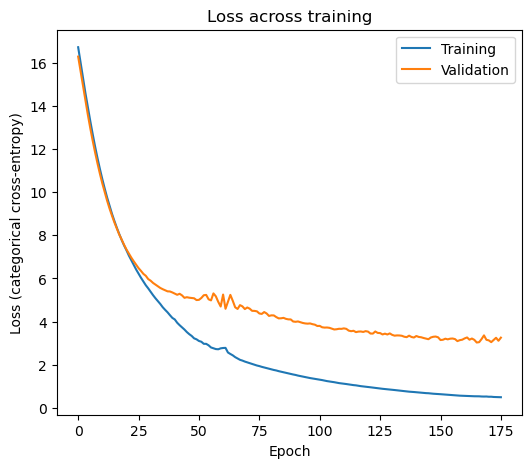

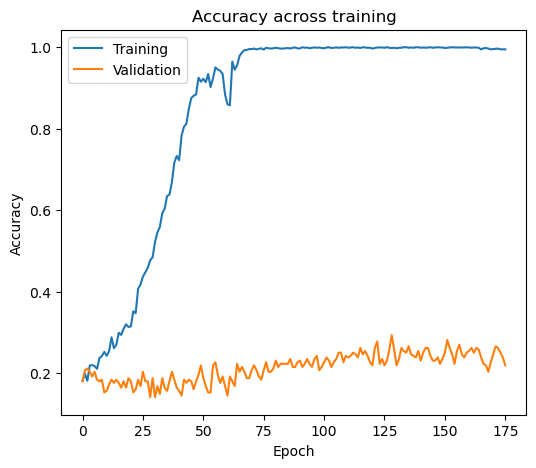

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(len(history.history['loss']))
y_train = history.history['loss']
y_validation = history.history['val_loss']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Loss across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (categorical cross-entropy)')
ax.legend()
plt.savefig(f'figures/event_loss_curve_CNN_kappa{kappa}-{nevent}.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,5))

x = range(len(history.history['accuracy']))
y_train = history.history['accuracy']
y_validation = history.history['val_accuracy']

ax.plot(x, y_train, label='Training')
ax.plot(x, y_validation, label='Validation')

ax.set_title('Accuracy across training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.savefig(f'figures/event_accuracy_curve_CNN_kappa{kappa}-{nevent}.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

# Training results

## Model

In [14]:
kappa = 0.15
nevent = '10k'
save_model_name = f'best_model/best_model_event_CNN_kappa{kappa}-{nevent}/'
loaded_model = tf.keras.models.load_model(save_model_name)

## Testing data

In [17]:
kappa = 0.15
nevent = '10k'
batch_size = 512
dim_image = [[75, 75], [[-0.8, 0.8], [-0.8, 0.8]]]
sample_dir = f'/home/r10222035/Boosted_V/sample/event_samples_kappa{kappa}-{nevent}/'
data_te = os.path.join(sample_dir, 'test.tfrecord')
dataset_te, te_total = get_dataset(data_te, repeat=False, 
                                   batch_size=batch_size, 
                                   dim_image=dim_image+[True], 
                                   shuffle=0)

The data set contains images


In [18]:
results = loaded_model.evaluate(dataset_te)

print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

1/1 [==============================] - 1s 799ms/step - loss: 2.9692 - accuracy: 0.2734
Testing Loss = 2.97, Testing Accuracy = 0.273


## Plot ROC

In [19]:
labels = np.vstack([x[1] for x in dataset_te])

predictions = loaded_model.predict(dataset_te).tolist()

2/2 [==============================] - 0s 31ms/step


In [20]:
print(labels[:10])
print(predictions[:10])

y_test = np.argmax(labels, axis=1)
y_prob = np.array(predictions)

print(y_test[:10])
print(y_prob[:10])

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]
[[0.003851170651614666, 0.0006572864367626607, 0.0020876042544841766, 0.4753216803073883, 0.001904933713376522, 0.5161772966384888], [0.0010229271138086915, 0.9809613823890686, 0.0017702752957120538, 0.004916687961667776, 0.00038650399073958397, 0.010942293331027031], [0.00044439241173677146, 0.8821572661399841, 0.0009704011026769876, 0.0016884180950000882, 0.0859765112400055, 0.028762973845005035], [0.00019877262820955366, 0.4283716380596161, 0.005306468345224857, 0.5538885593414307, 0.00431769248098135, 0.007916868664324284], [0.1878574639558792, 0.6343097686767578, 0.020887799561023712, 0.005365879274904728, 0.06196651607751846, 0.08961253613233566], [0.1763560175895691, 0.020371831953525543, 0.12091737240552902, 0.057688985019922256, 0.009496736340224743, 0.615169107913971],

Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 7690.48it/s]


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 8241.67it/s]


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 8191.12it/s]


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 8187.01it/s]


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 8199.50it/s]


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 8219.27it/s]


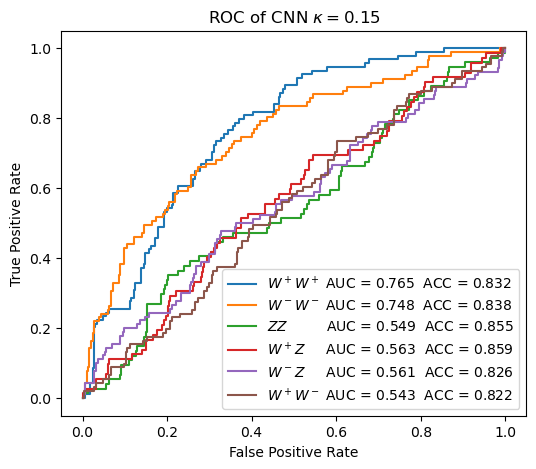

In [47]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

event_type = {0: '$W^+W^+$', 1: '$W^-W^-$', 2: '$ZZ$        ', 3:'$W^+Z$    ', 4:'$W^-Z$    ', 5:'$W^+W^-$'}
AUC = np.zeros(6)
ACC = np.zeros(6)
for i in range(6):
    AUC[i] = roc_auc_score(y_test==i,  y_prob[:,i])
    fpr, tpr, thresholds = roc_curve(y_test==i, y_prob[:,i])
    
    # 計算最高的正確率
    accuracy_scores = []
    print('Calculating ACC')
    thresholds = np.array(thresholds)
    # 最多用 1000 個
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0,100,1001))

    for threshold in tqdm(thresholds):
        accuracy_scores.append(accuracy_score(y_test==i,  y_prob[:,i]>threshold))

    accuracies = np.array(accuracy_scores)
    ACC[i] = accuracies.max() 
    
    ax.plot(fpr, tpr, label = f'{event_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')

ax.set_title(f'ROC of CNN $\kappa = {kappa}$')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

plt.savefig(f'figures/event_ROC_CNN_kappa{kappa}-{nevent}.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:15<00:00, 65.40it/s]
/tmp/ipykernel_853169/3837157490.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:14<00:00, 66.95it/s]
/tmp/ipykernel_853169/3837157490.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:14<00:00, 67.92it/s]
/tmp/ipykernel_853169/3837157490.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


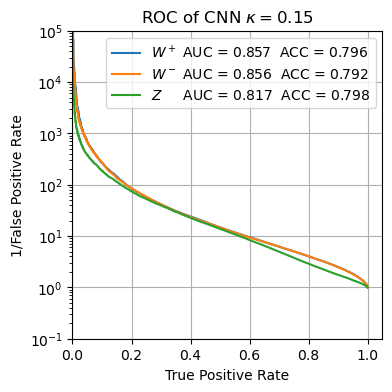

In [20]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

particle_type = {0: '$W^+$', 1: '$W^-$', 2: '$Z$    '}
AUC = [0,0,0]
ACC = [0,0,0]
for i in range(3):
    AUC[i] = roc_auc_score(y_test==i,  y_prob[:,i])
    fpr, tpr, thresholds = roc_curve(y_test==i, y_prob[:,i])

    # 計算最高的正確率
    accuracy_scores = []
    print('Calculating ACC')
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0,100,1001))

    for threshold in tqdm(thresholds):
        accuracy_scores.append(accuracy_score(y_test==i,  y_prob[:,i]>threshold))

    accuracies = np.array(accuracy_scores)
    ACC[i] = accuracies.max() 
    
    ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')

ax.set_title(f'ROC of CNN $\kappa = {kappa}$')
ax.set_xlabel('True Positive Rate')
ax.set_ylabel('1/False Positive Rate')
ax.set_xlim([0, 1.05])
ax.set_ylim([1e-1, 1e5])
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_yscale('log')
ax.legend()

# plt.savefig(f'figures/ROC_CNN_kappa{kappa}-{nevent}-pstyle.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:15<00:00, 65.81it/s]
/tmp/ipykernel_853169/3398711447.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:15<00:00, 65.63it/s]
/tmp/ipykernel_853169/3398711447.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


Calculating ACC


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:14<00:00, 67.94it/s]
/tmp/ipykernel_853169/3398711447.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')


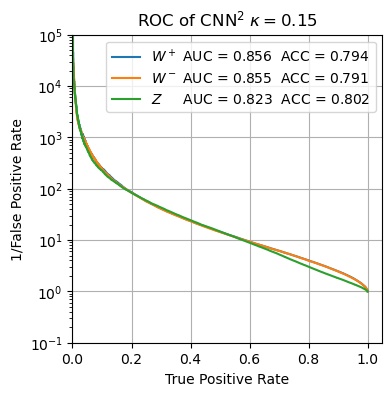

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

particle_type = {0: '$W^+$', 1: '$W^-$', 2: '$Z$    '}
AUC = [0,0,0]
ACC = [0,0,0]
for i in range(3):
    AUC[i] = roc_auc_score(y_test==i,  y_prob[:,i])
    fpr, tpr, thresholds = roc_curve(y_test==i, y_prob[:,i])

    # 計算最高的正確率
    accuracy_scores = []
    print('Calculating ACC')
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0,100,1001))

    for threshold in tqdm(thresholds):
        accuracy_scores.append(accuracy_score(y_test==i,  y_prob[:,i]>threshold))

    accuracies = np.array(accuracy_scores)
    ACC[i] = accuracies.max() 
    
    ax.plot(tpr, 1/fpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')

ax.set_title(f'ROC of CNN$^2$ $\kappa = {kappa}$')
ax.set_xlabel('True Positive Rate')
ax.set_ylabel('1/False Positive Rate')
ax.set_xlim([0, 1.05])
ax.set_ylim([1e-1, 1e5])
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_yscale('log')
ax.legend()

plt.savefig(f'figures/ROC_CNNsq_kappa{kappa}-{nevent}-pstyle.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

# Write training results

In [35]:
now = datetime.datetime.now()

In [36]:
file_name = 'event_training_results.csv'

In [41]:
event_type = ['W+W+', 'W-W-', 'ZZ', 'W+Z', 'W-Z', 'W+W-']
data_dict = {'kappa': [kappa],
            'Sample': [nevent],
            'Model': [model_name],
            'Overall ACC': [results[1]],
            'time': [now],
            }

for i, _type in enumerate(event_type):
    data_dict[f'Train {_type}'] = [train_size[i]]
    data_dict[f'Validation {_type}'] = [validation_size[i]]
    data_dict[f'Test {_type}'] = [test_size[i]]
    data_dict[f'{_type} AUC'] = [AUC[i]]
    data_dict[f'{_type} ACC'] = [ACC[i]]

In [43]:
df = pd.DataFrame(data_dict)
if os.path.isfile(file_name):
    training_results_df = pd.read_csv(file_name)
    pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
else:
    df.to_csv(file_name, index=False)